# EN 520.665 Project 1: CIFAR10 Classification
Author: Mo Zhou <mzhou32@jhu.edu>
Date: Nov. 17 2021

## Our Method

In this project, we train a standard ResNet-18 Model on the CIFAR-10 dataset
using the cross-entropy loss. SGD optimizer is used to update the model
parameters, with a learning rate 0.1 and momemtum 0.9. L-2 regularization
is also used with a weight 0.0002. The model is trained for 200 epoches
with a batch size 256. The learning rate is decayed by factor 0.1 at the
100th and the 150th epoch, respectively following the original paper.

The results and plots can be found in the last part. The experiment is
conducted with an Nvidia Titan Xp GPU.

## Code

The code is written on top of PyTorch and Pytorch-Lightning for convenience.
I borrowed some code from my own project: https://github.com/cdluminate/robrank.

In [1]:
import os
import numpy as np
import torch as th
from torch.utils.data import Dataset
import torchvision as V
import pickle
from PIL import Image
import pytorch_lightning as thl
from torch.utils.data import DataLoader

In [2]:
# configurations
cifar10_path = os.path.expanduser('~/.torch/cifar-10-batches-py')
batch_size = 256
learning_rate = 1e-1
momentum = 9e-1
weight_decay = 2e-4
maxepoch = 200
Imean = th.tensor([0.485, 0.456, 0.406])
Istd = th.tensor([0.229, 0.224, 0.225])

def unpickle(file):
    with open(file, 'rb') as fo:
        dic = pickle.load(fo, encoding='latin1')
    return dic

def renorm(im):
    return im.sub(Imean[:, None, None].to(im.device)).div(
        Istd[:,None,None].to(im.device))

In [3]:
# create dataset class
class Cifar10Dataset(Dataset):
    '''
    CIFAR 10 Dataset Class
    '''
    def __init__(self, path, kind):
        # determine type {train, test}
        if kind == 'train':
            transform = V.transforms.Compose([
                V.transforms.RandomCrop(32, padding=4),
                V.transforms.RandomHorizontalFlip(),
                V.transforms.ToTensor(),
            ])
        elif kind == 'test':
            transform = V.transforms.Compose([
                V.transforms.ToTensor(),
            ])
        else:
            raise ValueError
        self.transform = transform
        # load dataset
        if kind == 'train':
            files = [f'data_batch_{x}' for x in range(1, 5+1)]
            files = [os.path.join(path, x) for x in files]
            images, labels = [], []
            for i in files:
                data = unpickle(i)
                images.append(data['data'])
                labels.extend(data['labels'])
            images = np.vstack(images).reshape(-1, 3, 32, 32)
            labels = np.array(labels)
        elif kind == 'test':
            file = os.path.join(path, 'test_batch')
            data = unpickle(file)
            images = np.array(data['data']).reshape(-1, 3, 32, 32)
            labels = np.array(data['labels'])
        else:
            raise ValueError
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx].transpose((1,2,0)))
        label = self.labels[idx]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [4]:
# create resnet 18 model
class ResNet18(thl.LightningModule):
    
    def __init__(self):
        super().__init__()
        # create resnet18 backbone
        self.backbone = V.models.resnet18(False)
        # perform surgery
        self.backbone.fc = th.nn.Linear(512, 10)
        
    def setup(self, stage=None):
        # instantiate dataset objects
        TrainDataset = Cifar10Dataset(cifar10_path, 'train')
        TestDataset = Cifar10Dataset(cifar10_path, 'test')
        print('* training set size', len(TrainDataset))
        print('* test set size', len(TestDataset))
        self.data_train = TrainDataset
        self.data_val = TestDataset
        self.data_test = None
        
    def train_dataloader(self):
        train_loader = DataLoader(self.data_train,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  pin_memory=True,
                                  num_workers=4)
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(self.data_val,
                               batch_size=batch_size,
                               pin_memory=True,
                               num_workers=4)
        return val_loader
    
    def configure_optimizers(self):
        optim = th.optim.SGD(self.parameters(),
                    lr=learning_rate, momentum=momentum,
                    weight_decay=weight_decay)
        scheduler = th.optim.lr_scheduler.MultiStepLR(
            optim, milestones=[100, 150], gamma=0.1)
        return [optim], [scheduler]
    
    def forward(self, x):
        with th.no_grad():
            x = renorm(x)
        x = self.backbone(x)
        return x
    
    def training_step(self, batch, batch_idx):
        images, labels = (batch[0].to(self.device), batch[1].to(self.device))
        output = self.forward(images)
        loss = th.nn.functional.cross_entropy(output, labels)
        self.log('Train/loss', loss.item())
        accuracy = output.max(1)[1].eq(
            labels.view(-1)).sum().item() / labels.nelement()
        self.log('Train/accuracy', accuracy)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = (batch[0].to(self.device), batch[1].to(self.device))
        output = self.forward(images)
        loss = th.nn.functional.cross_entropy(output, labels)
        self.log('Val/loss', loss.item())
        accuracy = output.max(1)[1].eq(
            labels.view(-1)).sum().item() / labels.nelement()
        self.log('Val/accuracy', accuracy)
        return {'loss': loss.item(), 'accuracy': accuracy}
    
    def validation_epoch_end(self, outputs):
        summary = {key: np.mean(tuple(x[key] for x in outputs))
                   for key in outputs[0].keys()}
        print('Validation Summary: loss=',
              summary['loss'],
              'accuracy=',
              summary['accuracy'], end='')
        


In [5]:
# define training loop
class Train():
    def __init__(self):
        print('* Initializing model ...')
        model = ResNet18()
        
        print('* Start training loop ...')
        trainer = thl.Trainer(max_epochs=maxepoch,
                              log_every_n_steps=1,
                              check_val_every_n_epoch=1,
                              gpus=1, #th.cuda.device_count(),
                              accelerator='ddp')
        trainer.fit(model)
        print('* finished training ...')

In [6]:
# start training
Train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


* Initializing model ...
* Start training loop ...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/1


* training set size 50000
* test set size 10000



  | Name     | Type   | Params
------------------------------------
0 | backbone | ResNet | 11.2 M
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Validation Summary: loss= 2.333478808403015 accuracy= 0.11328125

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 1.5719489306211472 accuracy= 0.42080078125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 1.355274000763893 accuracy= 0.53115234375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 1.3385864064097404 accuracy= 0.56064453125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 1.124035057425499 accuracy= 0.60576171875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 1.0584546416997909 accuracy= 0.62998046875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.9785867214202881 accuracy= 0.66728515625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.96278817653656 accuracy= 0.6720703125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.8623888105154037 accuracy= 0.6994140625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.8447653636336326 accuracy= 0.69736328125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.8567550569772721 accuracy= 0.70771484375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.8347675532102585 accuracy= 0.70869140625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.7146277263760566 accuracy= 0.75595703125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.7275224655866623 accuracy= 0.7431640625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.758560860157013 accuracy= 0.74267578125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6756385371088982 accuracy= 0.76025390625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.7543443500995636 accuracy= 0.75

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.761492233723402 accuracy= 0.7443359375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6323633193969727 accuracy= 0.781640625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6870658077299595 accuracy= 0.766796875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6771755568683148 accuracy= 0.7708984375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6119501680135727 accuracy= 0.7912109375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6725631430745125 accuracy= 0.7705078125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6440955020487309 accuracy= 0.78203125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6766715750098229 accuracy= 0.780078125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6167709715664387 accuracy= 0.79326171875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6227638773620129 accuracy= 0.79443359375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5872392043471336 accuracy= 0.7953125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6417065098881721 accuracy= 0.78505859375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6184763178229332 accuracy= 0.78798828125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5703439846634865 accuracy= 0.80517578125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6273761220276356 accuracy= 0.7923828125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5908405669033527 accuracy= 0.79873046875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6172116659581661 accuracy= 0.7955078125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5570637702941894 accuracy= 0.81220703125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.606589087843895 accuracy= 0.80009765625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.617194376140833 accuracy= 0.8001953125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5919547364115715 accuracy= 0.80517578125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6016125835478305 accuracy= 0.792578125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6035500332713127 accuracy= 0.7955078125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6992100887000561 accuracy= 0.76923828125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5850346438586712 accuracy= 0.80615234375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5750300765037537 accuracy= 0.81416015625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6086239948868751 accuracy= 0.801953125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6014822833240032 accuracy= 0.80625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6365287579596043 accuracy= 0.7951171875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5986101448535919 accuracy= 0.80869140625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5895230054855347 accuracy= 0.80546875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5724939838051796 accuracy= 0.811328125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5856907896697521 accuracy= 0.8107421875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5762584179639816 accuracy= 0.81640625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5555527180433273 accuracy= 0.82705078125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5718503564596176 accuracy= 0.81767578125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6219490393996239 accuracy= 0.80439453125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5440866321325302 accuracy= 0.82529296875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5807734988629818 accuracy= 0.8111328125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5902116969227791 accuracy= 0.81181640625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5768497470766306 accuracy= 0.81611328125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.559658233821392 accuracy= 0.81884765625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5908588908612729 accuracy= 0.81240234375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5764903806149959 accuracy= 0.80751953125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5923024661839008 accuracy= 0.81328125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5584845952689648 accuracy= 0.8203125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5398909159004688 accuracy= 0.82373046875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6263121947646141 accuracy= 0.796875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5728555969893933 accuracy= 0.814453125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5963203832507133 accuracy= 0.815625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6025411777198315 accuracy= 0.80810546875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5995022468268871 accuracy= 0.81376953125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5907536029815674 accuracy= 0.8126953125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.56806935146451 accuracy= 0.81669921875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5590824633836746 accuracy= 0.8232421875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.586397971957922 accuracy= 0.8115234375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5749364241957664 accuracy= 0.81875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6161385640501976 accuracy= 0.80400390625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6007272522896528 accuracy= 0.80107421875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6012667946517467 accuracy= 0.8076171875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5907720565795899 accuracy= 0.8146484375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5421953462064266 accuracy= 0.83125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5682397954165935 accuracy= 0.82099609375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5535523995757103 accuracy= 0.8265625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5729731127619744 accuracy= 0.81171875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6229374364018441 accuracy= 0.81240234375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5483333624899387 accuracy= 0.82783203125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5864346213638783 accuracy= 0.81728515625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5618139762431383 accuracy= 0.81865234375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5648076869547367 accuracy= 0.82626953125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5479686904698611 accuracy= 0.8279296875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5301938474178314 accuracy= 0.83310546875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6383413441479207 accuracy= 0.80576171875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5718089625239372 accuracy= 0.81943359375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6177575908601284 accuracy= 0.81064453125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6842574760317802 accuracy= 0.79423828125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5679467357695103 accuracy= 0.8197265625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6022960379719734 accuracy= 0.8150390625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5856825962662697 accuracy= 0.81728515625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6035532556474209 accuracy= 0.80947265625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5703616254031658 accuracy= 0.8205078125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5579380422830582 accuracy= 0.82705078125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5864544674754143 accuracy= 0.81416015625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.557019080594182 accuracy= 0.8212890625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.43560357913374903 accuracy= 0.86533203125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.4427366077899933 accuracy= 0.866796875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.44430318400263785 accuracy= 0.86767578125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.4546850256621838 accuracy= 0.86904296875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.45596969947218896 accuracy= 0.8701171875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.47717736214399337 accuracy= 0.86640625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.46461058743298056 accuracy= 0.86884765625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.470114204287529 accuracy= 0.869140625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.4740915920585394 accuracy= 0.8673828125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.4874423507601023 accuracy= 0.86669921875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.48970811665058134 accuracy= 0.87041015625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.4980515334755182 accuracy= 0.87001953125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.49999207369983195 accuracy= 0.87109375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5061949983239173 accuracy= 0.8689453125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5038391306996346 accuracy= 0.8697265625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.516250703111291 accuracy= 0.86669921875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5233912549912929 accuracy= 0.86630859375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.522114922106266 accuracy= 0.8693359375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.529690558090806 accuracy= 0.8669921875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5523855365812779 accuracy= 0.86669921875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5458698874339462 accuracy= 0.86533203125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5493428770452737 accuracy= 0.87080078125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5481876961886882 accuracy= 0.86962890625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5550843302160502 accuracy= 0.86982421875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5661654889583587 accuracy= 0.86455078125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5642624884843827 accuracy= 0.86630859375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5671784151345491 accuracy= 0.86484375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5739845432341099 accuracy= 0.86591796875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5783980548381805 accuracy= 0.8673828125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5788789544254541 accuracy= 0.86376953125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5827510267496109 accuracy= 0.86376953125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5851840841583907 accuracy= 0.86787109375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5899426585063339 accuracy= 0.86513671875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.588272569514811 accuracy= 0.86884765625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6023102478124202 accuracy= 0.8673828125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5960938408970833 accuracy= 0.86865234375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5880665525794029 accuracy= 0.868359375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.596235615736805 accuracy= 0.8705078125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5906170986592769 accuracy= 0.86953125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.611452904343605 accuracy= 0.8669921875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6062188202515244 accuracy= 0.87080078125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.5927249907981604 accuracy= 0.87138671875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6021315850084648 accuracy= 0.86826171875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6147631311789155 accuracy= 0.86767578125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6201751267537474 accuracy= 0.86552734375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6222131100483239 accuracy= 0.86689453125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6280102346092462 accuracy= 0.86728515625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6305111581459641 accuracy= 0.868359375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6224103443324566 accuracy= 0.8658203125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6256889220327139 accuracy= 0.8642578125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6098345261067152 accuracy= 0.86748046875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6097218282520771 accuracy= 0.86767578125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6125049412250518 accuracy= 0.86953125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6117558959871531 accuracy= 0.869921875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6145485438406467 accuracy= 0.8697265625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6111521100625396 accuracy= 0.8697265625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6067535690963268 accuracy= 0.87119140625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6093178736045957 accuracy= 0.8734375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6180533533915877 accuracy= 0.87236328125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.613771332334727 accuracy= 0.8712890625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6192941458895802 accuracy= 0.87333984375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6165025062859059 accuracy= 0.87109375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6154682198539376 accuracy= 0.87509765625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6202364880591631 accuracy= 0.87109375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.619309070520103 accuracy= 0.87109375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6189511343836784 accuracy= 0.8728515625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6213332410901785 accuracy= 0.8732421875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6236913368105889 accuracy= 0.87265625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6211217882111668 accuracy= 0.874609375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6201856524683536 accuracy= 0.87470703125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6227305853739381 accuracy= 0.8759765625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6278669206425548 accuracy= 0.87333984375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6292258750647306 accuracy= 0.87177734375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6287868646904826 accuracy= 0.87578125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6285518625751138 accuracy= 0.87421875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6324538075365126 accuracy= 0.8755859375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6252026744186878 accuracy= 0.875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6331520088948309 accuracy= 0.87490234375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6355431827716529 accuracy= 0.87353515625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6337366162799298 accuracy= 0.8751953125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6301226132549346 accuracy= 0.87568359375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6313173549249769 accuracy= 0.87490234375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6360757456161081 accuracy= 0.87451171875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6333043165504932 accuracy= 0.8748046875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6361026957631111 accuracy= 0.8728515625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6414953643456102 accuracy= 0.87333984375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6407956866547465 accuracy= 0.8734375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6425489247776568 accuracy= 0.87412109375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6380377668421715 accuracy= 0.87548828125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6398351761978119 accuracy= 0.87578125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6499551444780082 accuracy= 0.87431640625

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6479213822633028 accuracy= 0.873828125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6488297568634153 accuracy= 0.873828125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6448305930010975 accuracy= 0.8740234375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6451935838907957 accuracy= 0.87421875

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6468406081199646 accuracy= 0.8751953125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6467198669910431 accuracy= 0.87548828125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6479262600652873 accuracy= 0.8751953125

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6492047257721424 accuracy= 0.874609375

Validating: 0it [00:00, ?it/s]

Validation Summary: loss= 0.6499844034202397 accuracy= 0.87392578125* finished training ...


Text(0, 0.5, 'Accuracy')

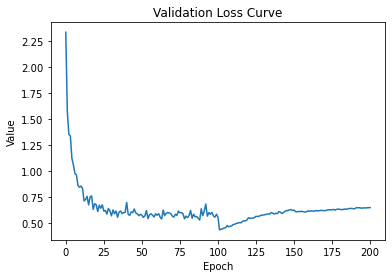

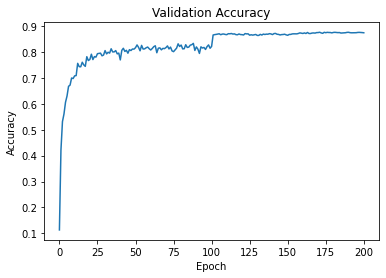

In [12]:
loss_curve = [2.333478808403015, 1.5719489306211472, 1.355274000763893, 1.3385864064097404, 1.124035057425499, 1.0584546416997909, 0.9785867214202881, 0.96278817653656, 0.8623888105154037, 0.8447653636336326, 0.8567550569772721, 0.8347675532102585, 0.7146277263760566, 0.7275224655866623, 0.758560860157013, 0.6756385371088982, 0.7543443500995636, 0.761492233723402, 0.6323633193969727, 0.6870658077299595, 0.6771755568683148, 0.6119501680135727, 0.6725631430745125, 0.6440955020487309, 0.6766715750098229, 0.6167709715664387, 0.6227638773620129, 0.5872392043471336, 0.6417065098881721, 0.6184763178229332, 0.5703439846634865, 0.6273761220276356, 0.5908405669033527, 0.6172116659581661, 0.5570637702941894, 0.606589087843895, 0.617194376140833, 0.5919547364115715, 0.6016125835478305, 0.6035500332713127, 0.6992100887000561, 0.5850346438586712, 0.5750300765037537, 0.6086239948868751, 0.6014822833240032, 0.6365287579596043, 0.5986101448535919, 0.5895230054855347, 0.5724939838051796, 0.5856907896697521, 0.5762584179639816, 0.5555527180433273, 0.5718503564596176, 0.6219490393996239, 0.5440866321325302, 0.5807734988629818, 0.5902116969227791, 0.5768497470766306, 0.559658233821392, 0.5908588908612729, 0.5764903806149959, 0.5923024661839008, 0.5584845952689648, 0.5398909159004688, 0.6263121947646141, 0.5728555969893933, 0.5963203832507133, 0.6025411777198315, 0.5995022468268871, 0.5907536029815674, 0.56806935146451, 0.5590824633836746, 0.586397971957922, 0.5749364241957664, 0.6161385640501976, 0.6007272522896528, 0.6012667946517467, 0.5907720565795899, 0.5421953462064266, 0.5682397954165935, 0.5535523995757103, 0.5729731127619744, 0.6229374364018441, 0.5483333624899387, 0.5864346213638783, 0.5618139762431383, 0.5648076869547367, 0.5479686904698611, 0.5301938474178314, 0.6383413441479207, 0.5718089625239372, 0.6177575908601284, 0.6842574760317802, 0.5679467357695103, 0.6022960379719734, 0.5856825962662697, 0.6035532556474209, 0.5703616254031658, 0.5579380422830582, 0.5864544674754143, 0.557019080594182, 0.43560357913374903, 0.4427366077899933, 0.44430318400263785, 0.4546850256621838, 0.45596969947218896, 0.47717736214399337, 0.46461058743298056, 0.470114204287529, 0.4740915920585394, 0.4874423507601023, 0.48970811665058134, 0.4980515334755182, 0.49999207369983195, 0.5061949983239173, 0.5038391306996346, 0.516250703111291, 0.5233912549912929, 0.522114922106266, 0.529690558090806, 0.5523855365812779, 0.5458698874339462, 0.5493428770452737, 0.5481876961886882, 0.5550843302160502, 0.5661654889583587, 0.5642624884843827, 0.5671784151345491, 0.5739845432341099, 0.5783980548381805, 0.5788789544254541, 0.5827510267496109, 0.5851840841583907, 0.5899426585063339, 0.588272569514811, 0.6023102478124202, 0.5960938408970833, 0.5880665525794029, 0.596235615736805, 0.5906170986592769, 0.611452904343605, 0.6062188202515244, 0.5927249907981604, 0.6021315850084648, 0.6147631311789155, 0.6201751267537474, 0.6222131100483239, 0.6280102346092462, 0.6305111581459641, 0.6224103443324566, 0.6256889220327139, 0.6098345261067152, 0.6097218282520771, 0.6125049412250518, 0.6117558959871531, 0.6145485438406467, 0.6111521100625396, 0.6067535690963268, 0.6093178736045957, 0.6180533533915877, 0.613771332334727, 0.6192941458895802, 0.6165025062859059, 0.6154682198539376, 0.6202364880591631, 0.619309070520103, 0.6189511343836784, 0.6213332410901785, 0.6236913368105889, 0.6211217882111668, 0.6201856524683536, 0.6227305853739381, 0.6278669206425548, 0.6292258750647306, 0.6287868646904826, 0.6285518625751138, 0.6324538075365126, 0.6252026744186878, 0.6331520088948309, 0.6355431827716529, 0.6337366162799298, 0.6301226132549346, 0.6313173549249769, 0.6360757456161081, 0.6333043165504932, 0.6361026957631111, 0.6414953643456102, 0.6407956866547465, 0.6425489247776568, 0.6380377668421715, 0.6398351761978119, 0.6499551444780082, 0.6479213822633028, 0.6488297568634153, 0.6448305930010975, 0.6451935838907957, 0.6468406081199646, 0.6467198669910431, 0.6479262600652873, 0.6492047257721424, 0.6499844034202397]
accuracy_curve = [0.11328125, 0.42080078125, 0.53115234375, 0.56064453125, 0.60576171875, 0.62998046875, 0.66728515625, 0.6720703125, 0.6994140625, 0.69736328125, 0.70771484375, 0.70869140625, 0.75595703125, 0.7431640625, 0.74267578125, 0.76025390625, 0.75, 0.7443359375, 0.781640625, 0.766796875, 0.7708984375, 0.7912109375, 0.7705078125, 0.78203125, 0.780078125, 0.79326171875, 0.79443359375, 0.7953125, 0.78505859375, 0.78798828125, 0.80517578125, 0.7923828125, 0.79873046875, 0.7955078125, 0.81220703125, 0.80009765625, 0.8001953125, 0.80517578125, 0.792578125, 0.7955078125, 0.76923828125, 0.80615234375, 0.81416015625, 0.801953125, 0.80625, 0.7951171875, 0.80869140625, 0.80546875, 0.811328125, 0.8107421875, 0.81640625, 0.82705078125, 0.81767578125, 0.80439453125, 0.82529296875, 0.8111328125, 0.81181640625, 0.81611328125, 0.81884765625, 0.81240234375, 0.80751953125, 0.81328125, 0.8203125, 0.82373046875, 0.796875, 0.814453125, 0.815625, 0.80810546875, 0.81376953125, 0.8126953125, 0.81669921875, 0.8232421875, 0.8115234375, 0.81875, 0.80400390625, 0.80107421875, 0.8076171875, 0.8146484375, 0.83125, 0.82099609375, 0.8265625, 0.81171875, 0.81240234375, 0.82783203125, 0.81728515625, 0.81865234375, 0.82626953125, 0.8279296875, 0.83310546875, 0.80576171875, 0.81943359375, 0.81064453125, 0.79423828125, 0.8197265625, 0.8150390625, 0.81728515625, 0.80947265625, 0.8205078125, 0.82705078125, 0.81416015625, 0.8212890625, 0.86533203125, 0.866796875, 0.86767578125, 0.86904296875, 0.8701171875, 0.86640625, 0.86884765625, 0.869140625, 0.8673828125, 0.86669921875, 0.87041015625, 0.87001953125, 0.87109375, 0.8689453125, 0.8697265625, 0.86669921875, 0.86630859375, 0.8693359375, 0.8669921875, 0.86669921875, 0.86533203125, 0.87080078125, 0.86962890625, 0.86982421875, 0.86455078125, 0.86630859375, 0.86484375, 0.86591796875, 0.8673828125, 0.86376953125, 0.86376953125, 0.86787109375, 0.86513671875, 0.86884765625, 0.8673828125, 0.86865234375, 0.868359375, 0.8705078125, 0.86953125, 0.8669921875, 0.87080078125, 0.87138671875, 0.86826171875, 0.86767578125, 0.86552734375, 0.86689453125, 0.86728515625, 0.868359375, 0.8658203125, 0.8642578125, 0.86748046875, 0.86767578125, 0.86953125, 0.869921875, 0.8697265625, 0.8697265625, 0.87119140625, 0.8734375, 0.87236328125, 0.8712890625, 0.87333984375, 0.87109375, 0.87509765625, 0.87109375, 0.87109375, 0.8728515625, 0.8732421875, 0.87265625, 0.874609375, 0.87470703125, 0.8759765625, 0.87333984375, 0.87177734375, 0.87578125, 0.87421875, 0.8755859375, 0.875, 0.87490234375, 0.87353515625, 0.8751953125, 0.87568359375, 0.87490234375, 0.87451171875, 0.8748046875, 0.8728515625, 0.87333984375, 0.8734375, 0.87412109375, 0.87548828125, 0.87578125, 0.87431640625, 0.873828125, 0.873828125, 0.8740234375, 0.87421875, 0.8751953125, 0.87548828125, 0.8751953125, 0.874609375, 0.87392578125]
import matplotlib.pyplot as plt
plt.figure()
t = range(len(loss_curve))
plt.plot(t, loss_curve)
plt.title('Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.figure()
plt.plot(t, accuracy_curve)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')